In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus= tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)   # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

float_pres = 'float64' # Definindo a precisão padrão para as análises

In [2]:
Sim_Z, Sim_step_Z, DerivadaEspacial_Z, Get_weights_Z=create_simulation(API_TensorFlow,burgers_equation,WENO_Z)
Sim_JS, Sim_step_JS, DerivadaEspacial_JS, Get_weights_JS=create_simulation(API_TensorFlow,burgers_equation,WENO_JS)

In [6]:
# Criando uma camada de Burgers que integra o WENO à rede neural
Δx = 0.01
CFL=0.5
Sim_layer = WENO_temporal(Δx, CFL, Δx*CFL, FronteiraFixa,burgers_equation,WENO_JS)
Sim_net, Sim_step_net, DerivadaEspacial_net, Get_weights_net=tf.function(Sim_layer.Sim), tf.function(Sim_layer.Sim_step), tf.function(Sim_layer.DerivadaEspacial), tf.function(Sim_layer.Get_weights)

In [7]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([200], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando a rede neural
Network = keras.Model(input_x, Sim_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['MSE'])
# Carregando os pesos da rede neural treinados
#Network.load_weights('Modelo artigo')

In [19]:
# Carregando os pesos treinados
Network.load_weights('Modelos treinados\\Modelo Rede espacial - 2')

In [23]:
# Visualizando os resultados

Δx_ref = 0.01                                  # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: (-np.sin(np.pi*x) - 0.5 * x**3 + \
    np.where(x < 0, 0.0, 1.0))

CFL = 0.5 # Constante utilizada para determinar o tamanho da malha temporal
T   = 0.5     # Instante de tempo final

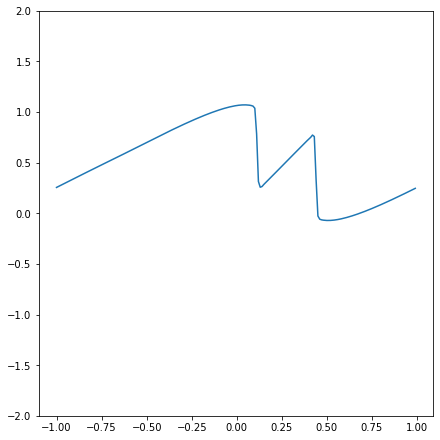

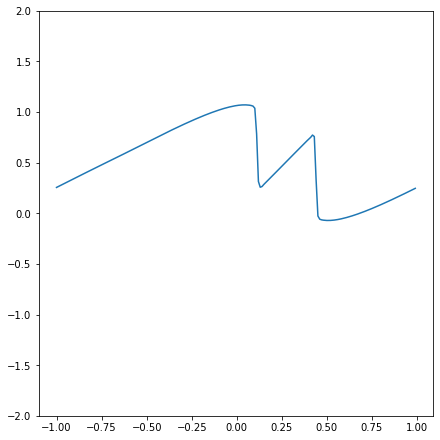

In [24]:
Δx=Δx_ref
x  = np.arange(-1, 1, Δx, dtype=float_pres)

u_Z = f_test(x)
u_Z = np.expand_dims(u_Z,axis=0)
t=0
Δt=0.05

fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax  = fig.add_subplot(1, 1, 1)
ax.set_ylim(-2, 2)
# ax.set_xlim(0,1)
line = ax.plot(x, tf.squeeze(u_Z))
hfig = display(fig, display_id=True)

while t < T:
    u_Z = Sim_net(u_Z,
              Δt,
              Δx,
              CFL,
              FronteiraPeriodica
                 )    
    t += Δt
    
    squeezed_u=np.squeeze(u_Z)
        
    # Exibindo graficamente os valores obtidos
    line[0].set_ydata(squeezed_u)
    fig.canvas.draw()
    hfig.update(fig)
    print('t: ',np.squeeze(t),'                                ',end='\r')

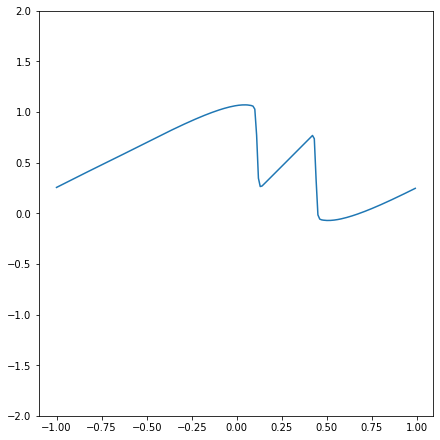

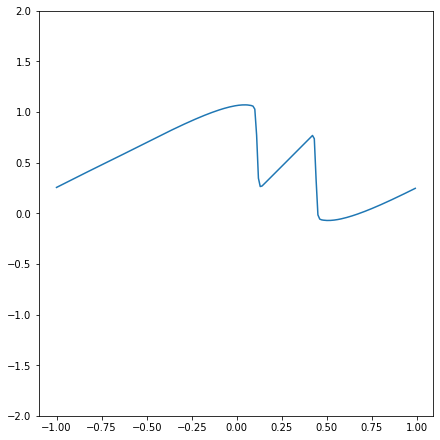

In [25]:
Δx=Δx_ref
x  = np.arange(-1, 1, Δx, dtype=float_pres)

u_net = f_test(x)
u_net = np.expand_dims(u_net,axis=0)
t=0
Δt=0.05

fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax  = fig.add_subplot(1, 1, 1)
ax.set_ylim(-2, 2)
# ax.set_xlim(0,1)
line = ax.plot(x, tf.squeeze(u_net))
hfig = display(fig, display_id=True)

while t < T:
    u_net = Sim_Z(u_net,
              Δt,
              Δx,
              CFL,
              FronteiraPeriodica
                 )    
    t += Δt
    
    squeezed_u=np.squeeze(u_net)
        
    # Exibindo graficamente os valores obtidos
    line[0].set_ydata(squeezed_u)
    fig.canvas.draw()
    hfig.update(fig)
    print('t: ',np.squeeze(t),'                                ',end='\r')

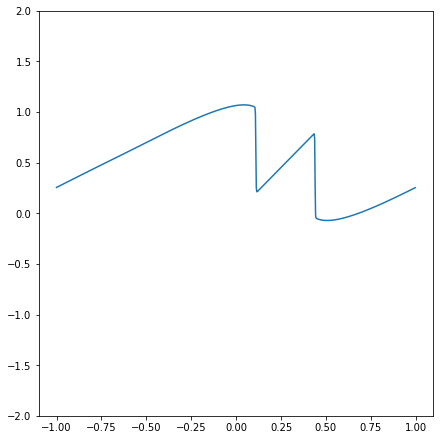

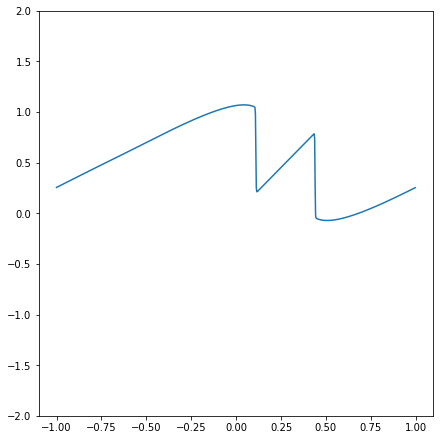

In [26]:
Δx=Δx_ref/4
x  = np.arange(-1, 1, Δx, dtype=float_pres)

u_ref = f_test(x)
u_ref = np.expand_dims(u_ref,axis=0)
t=0
Δt=0.05

fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax  = fig.add_subplot(1, 1, 1)
ax.set_ylim(-2, 2)
# ax.set_xlim(0,1)
line = ax.plot(x, tf.squeeze(u_ref))
hfig = display(fig, display_id=True)

while t < T:
    u_ref = Sim_Z(u_ref,
              Δt,
              Δx,
              CFL,
              FronteiraPeriodica
                 )    
    t += Δt
    
    squeezed_u=np.squeeze(u_ref)
        
    # Exibindo graficamente os valores obtidos
    line[0].set_ydata(squeezed_u)
    fig.canvas.draw()
    hfig.update(fig)
    print('t: ',np.squeeze(t),'                                ',end='\r')

In [27]:
ref_full = tf.gather(u_ref,(np.arange(u_net.shape[1])*4).astype('int32'),axis=1)
net_u    = u_net
debug_u  = tf.gather(u_Z,(np.arange(u_net.shape[1])*2).astype('int32'),axis=1)

# Armazenando ambos os erros de previsão
error = tf.stack([tf.squeeze(net_u)-tf.squeeze(ref_full),tf.squeeze(tf.squeeze(debug_u)-tf.squeeze(ref_full))],axis=0)

In [28]:
# Calculando média dos erros de acordo com a norma L2, L1 ou L-inf

# Norma L2:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_mean(error**2, axis=1)**0.5
#--------------------------------------------------------------------------------------
print('L2:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Norma L1:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_mean(tf.abs(error), axis=1)
#--------------------------------------------------------------------------------------
print('L1:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Noma L-inf:
#-------------------------------------------------------------------------------------
desv_error = tf.math.reduce_max(tf.abs(error), axis=1)
#--------------------------------------------------------------------------------------
print('L-inf:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())

L2:
[0.01849663 0.51095655]
0.03620001075558105


L1:
[0.00431577 0.38486165]
0.011213829280017436


L-inf:
[0.19871359 1.07090948]
0.18555591903343724


In [43]:
# Visualizando os resultados

Δx = 0.01                                  # Distância espacial dos pontos na malha utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

# Condição inicial do artigo do WENO-Z
# Função definida no artigo
f_test = lambda x: -tf.math.sin(np.pi*x) - 0.5 * x**3 + \
    tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres))

u = f_test(x)                 # Obtendo a condição inicial a partir de f_test
u = tf.expand_dims(u, axis=0) # Acrescentando uma dimensão

In [47]:
δ_Z.shape

TensorShape([])

In [49]:
# Código que utiliza a fução pega_ponto para salvar os pesos gerados 
# por cada uma das versões do WENO de interesse

n_pontos  = 9   # Número de substêncis coletados
mid_point = 100 # Índice do ponto 'central'

y_plot_Rede = np.zeros([n_pontos,3]) # Array para salvar os valores dos pesos do WENO-Z com rede neural
y_plot_Z    = np.zeros([n_pontos,3]) # Array para salvar os valores dos pesos do WENO-Z
y_plot_JS    = np.zeros([n_pontos,3]) # Array para salvar os valores dos pesos do WENO-JS

#u0=slicer(FronteiraFixa(u,API_Numpy),5,API_Numpy)[0,1:-1]
ω_net,α_net,β_net,δ_net = Get_weights_net(u,FronteiraFixa)
#ω_net = np.expand_dims(ω_net[:,3],axis=0)
ω_Z,α_Z,β_Z,δ_Z    = Get_weights_Z(u,FronteiraFixa)
ω_JS,α_JS,β_JS,δ_JS    = Get_weights_JS(u,FronteiraFixa)

for i in range(n_pontos):
    
    indice = int(mid_point-(n_pontos-1)/2+i) # Determinadno o índice para a função
    
    y_plot_JS[i] = np.squeeze(ω_JS)[indice] # Armazenando os pesos do WENO-Z com rede neural
    y_plot_Z[i]    = np.squeeze(ω_Z)[indice] # Armazenando os pesos do WENO-Z
    y_plot_Rede[i] = np.squeeze(ω_net)[indice] # Armazenando os pesos do WENO-Z com rede neural

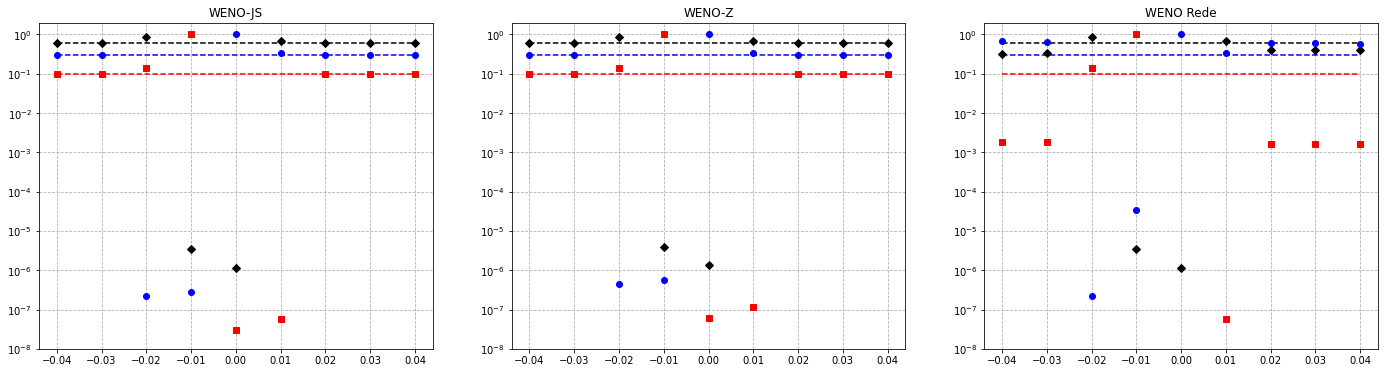

In [50]:
# Código que gera os gráficos comparando os pesos do WENO-Z e os pesos do WENO-Z
# modificados pela rede neural

# Criando os objetos que irão conter os plots
fig, axs = plt.subplots(1,3,figsize=(8*3, 6))

# Variáveis auxiliares para ajustar os limites dos gráficos
ylim  = (10**-8,2)
min_x = int(mid_point-(n_pontos-1)/2)
max_x = int(mid_point+(n_pontos+1)/2)

for i,y_plot,name in zip(range(3),[y_plot_JS,y_plot_Z,y_plot_Rede],['WENO-JS','WENO-Z','WENO Rede']):

    # Inserindo os pontos nos gráficos
    axs[i].plot(x[min_x:max_x], y_plot[:,0], 's', color='red'  , alpha=1)
    axs[i].plot(x[min_x:max_x], y_plot[:,1], 'D', color='black', alpha=1)
    axs[i].plot(x[min_x:max_x], y_plot[:,2], 'o', color='blue' , alpha=1)

    # Criando as linhas horizontais dos gráficos
    axs[i].hlines(
        y          = 1/10,
        xmin       = min(x[min_x:max_x]),
        xmax       = max(x[min_x:max_x]),
        color      = 'red',
        linestyles = '--'
    )
    axs[i].hlines(
        y          = 6/10,
        xmin       = min(x[min_x:max_x]),
        xmax       = max(x[min_x:max_x]),
        color      = 'black',
        linestyles = '--'
    )
    axs[i].hlines(
        y          = 3/10,
        xmin       = min(x[min_x:max_x]),
        xmax       = max(x[min_x:max_x]),
        color      = 'blue',
        linestyles = '--'
    )

    # Configuração de parâmetros gráficos referentes ao eixo y
    axs[i].set_yscale('log')
    axs[i].set_ylim(*ylim)
    axs[i].yaxis.set_ticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
    axs[i].grid(ls='--')
    axs[i].title.set_text(name)

# Exibindo os gráficos
plt.show()

In [ ]:
plt.plot(x[95:105],np.squeeze(u)[95:105])